# Twitter sentiment analysis
##### The aim of the project is to predict the sentiment (positive/negative) of tweets, with the help of separate words, and their connections. 
##### Around 1.6 million tweets are to be analysed. Such program can be used by political agencies, advertising companies, or other.

# 1. Importing libraries

In [120]:

from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter 
import seaborn as sns
import re
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### ABOUT THE DATASET 
#### The dataset consists of 1.6 million tweet, usually in a form of a sentence, or a few of them. The other parts, for example user ID, or the date of creating the tweet are also present, however they will be deleted soon.

In [126]:
import pandas as pd
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin-1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


# 3.1 Data pre-preprocessing

#### Here, only the sentiment of the tweet and the text are left, however if the separate words are to be investigated, the things such as punctuation marks should be deleted

In [127]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.loc[df['sentiment'] == 4, 'sentiment'] = 1
df.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


# Natural language processing (stopwords removal and stemming)  

In [128]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet resources if not already downloaded
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [73]:
def preprocess2(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|\w*\d\w*|[^A-Za-z0-9]+|www?:\S", ' ', str(text).lower())
    text = text.strip()
    tokens = []
    tokens_not_stemmed = []
    for word in text.split():
        if word not in stop_words:
            tokens_not_stemmed.append(word)
            if stemmer.stem(word) != word: #checks whether stemming is possible
                tokens.append(stemmer.stem(word))
            else:
                tokens.append(word)
    return " ".join(tokens)

In [134]:
def preprocess(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|\w*\d\w*|[^A-Za-z0-9]+|www?:\S", ' ', str(text).lower())
    text = text.strip()
    tokens = []
    tokens_not_lemma = []
    for word in text.split():
        if word not in stop_words:
            tokens_not_lemma.append(word)
            if lemmatizer.lemmatize(word) != word: #checks whether stemming is possible
                tokens.append(lemmatizer.lemmatize(word))
            else:
                tokens.append(word)
    return " ".join(tokens)

In [135]:
df.text = df.text.apply(lambda x: preprocess(x))
df.head()

,sentiment,text
0,0,upset update facebook texting might cry result...
1,0,dived many time ball managed save rest go bound
2,0,whole body feel itchy like fire
3,0,behaving mad see
4,0,whole crew


# 4. Most often occuring words

In [136]:
positive_tweets = df[df.sentiment == 1]
negative_tweets = df[df.sentiment == 0]

Text(0.5, 1.0, 'Top 15 Most Occurring Words in Positive Tweets')

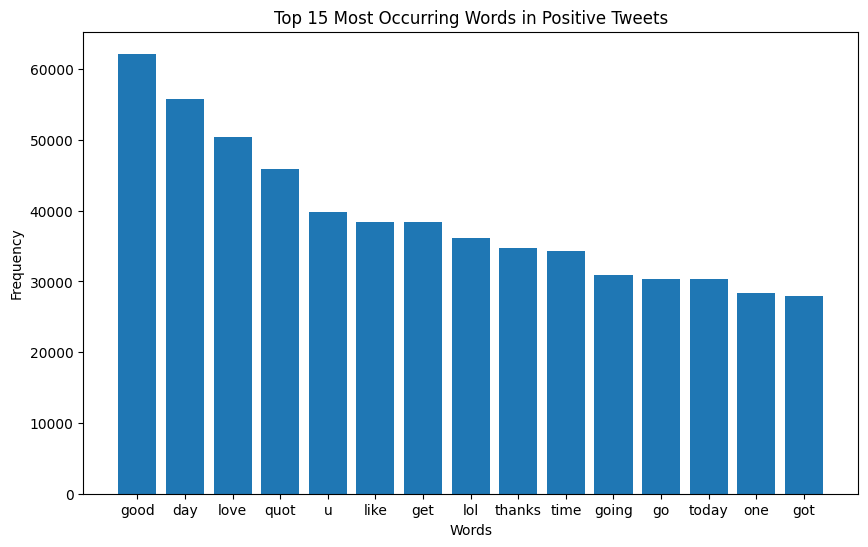

In [137]:
pos_words = " ".join(positive_tweets.text)
pos_words = pos_words.split() 

pos_words_freq = Counter(pos_words)

most_occur = pos_words_freq.most_common(15) 
words, frequencies = zip(*most_occur)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Occurring Words in Positive Tweets')


Text(0.5, 1.0, 'Top 15 Most Occurring Words in negative Tweets')

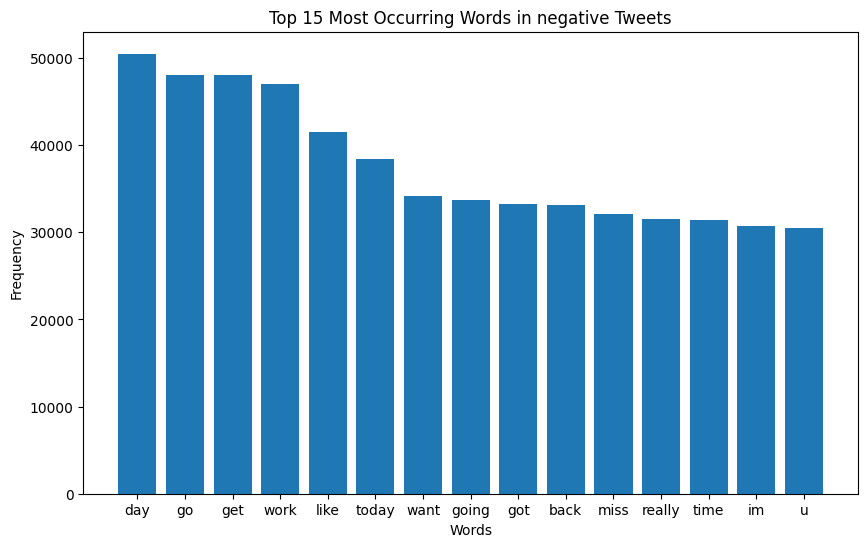

In [138]:
neg_words = " ".join(negative_tweets.text)
neg_words = neg_words.split() 

neg_words_freq = Counter(neg_words)
most_occur2 = neg_words_freq.most_common(15)
words2, frequencies2 = zip(*most_occur2)
plt.figure(figsize=(10, 6))
plt.bar(words2, frequencies2)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Occurring Words in negative Tweets')

# 5. Logistic regression and naive bayes model creation + checking which words have the biggest "power" according to tfidf

In [139]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000000000)
X = tfidf_vectorizer.fit_transform(df['text'])


In [140]:
y = df['sentiment']


In [141]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
model = LogisticRegression()
###used to find the best parameters
'''param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 300, 1000]
}'''
param_grid = {
    'penalty': ['l2'], #l2 better
    'C': [1], #around 1 the best
    'solver': ['liblinear'], #liblinear and saga yield very similar results
    'max_iter': [1000] #lets see
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
#Logistic regression default model

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)


Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.7777037319451199
Test Score: 0.778946875


In [81]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
model1 = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear', max_iter= 1000)

model1.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [82]:
#Naive Bayes default model
model2 = MultinomialNB(alpha= 0.1)
model2.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

## 5.1 Which words make tweets positive/negative

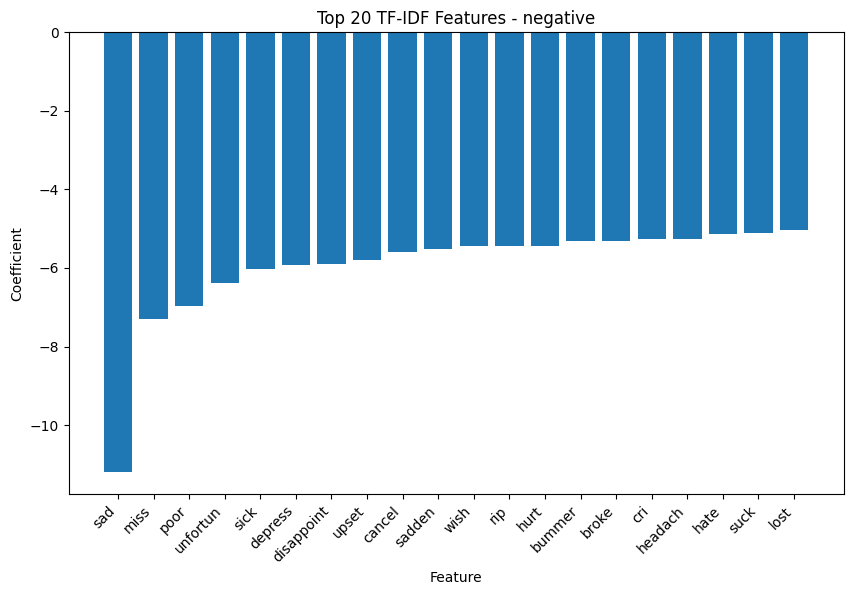

In [83]:

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model1.coef_.flatten()

#Create a df to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=True)

#Display top 20 most important features
top_features = feature_importance_df.head(20)  # Adjust N as needed
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 TF-IDF Features - negative')
plt.xticks(rotation=45, ha='right')
plt.show()

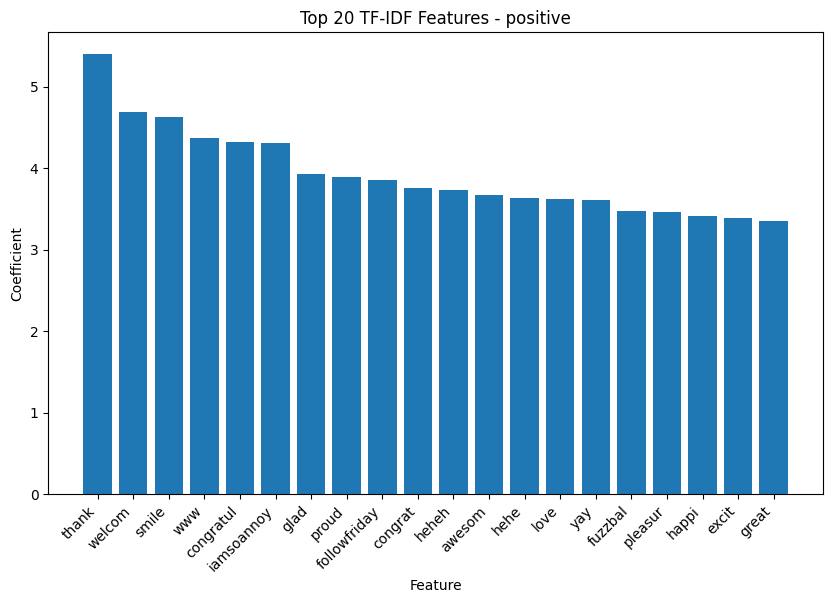

In [84]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model1.coef_.flatten()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)

top_features = feature_importance_df.head(20) 
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 TF-IDF Features - positive')
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Model evaluation logistic regression and naive bayes

In [85]:
y_pred = model1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred)

print(f'Accuracy - logistic regression: {accuracy1:.2f}')

print(classification_report(y_test, y_pred))
conf_matrix1 = confusion_matrix(y_test, y_pred)

Accuracy - logistic regression: 0.77
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159911
           1       0.76      0.80      0.78    160089

    accuracy                           0.77    320000
   macro avg       0.78      0.77      0.77    320000
weighted avg       0.78      0.77      0.77    320000



In [86]:
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)

print(f'Accuracy - Naive bayes: {accuracy2:.2f}')

print(classification_report(y_test, y_pred2))
conf_matrix2 = confusion_matrix(y_test, y_pred2)

Accuracy - Naive bayes: 0.75
              precision    recall  f1-score   support

           0       0.74      0.76      0.75    159911
           1       0.76      0.74      0.75    160089

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



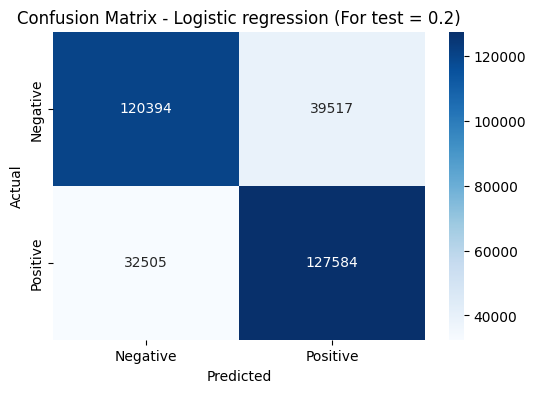

In [87]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic regression (For test = 0.2)')
plt.show()

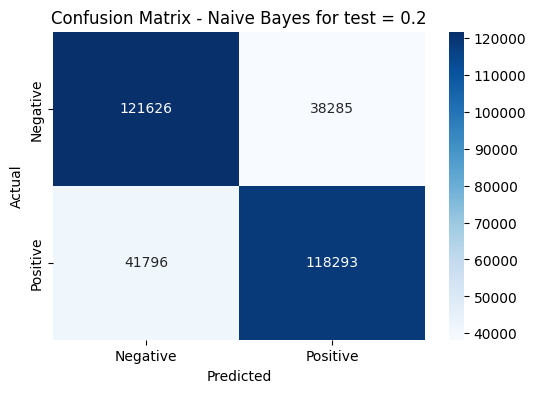

In [88]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes for test = 0.2')
plt.show()

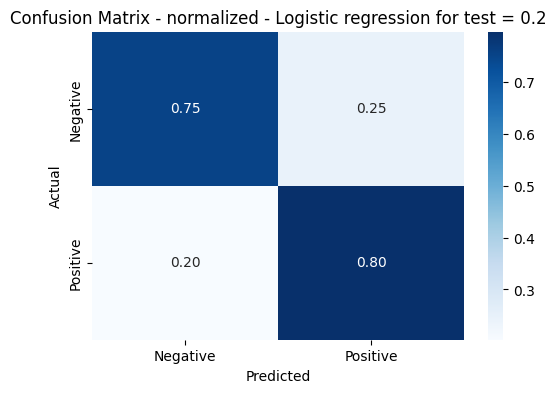

In [89]:
#creating a normalised matrix
conf_matrix1_normalised = conf_matrix1.astype('float') / conf_matrix1.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix1_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - normalized - Logistic regression for test = 0.2')
plt.show()

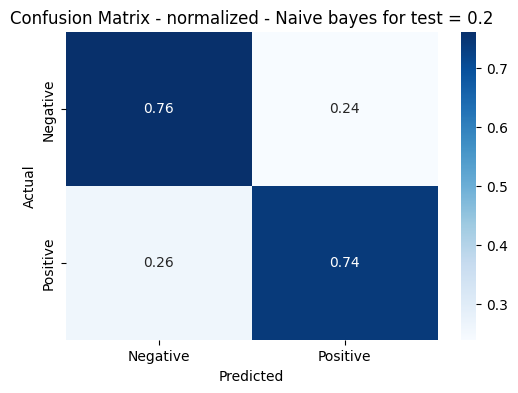

In [90]:
conf_matrix2_normalised = conf_matrix2.astype('float') / conf_matrix2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - normalized - Naive bayes for test = 0.2')
plt.show()


## 6.2 Checking how the model behaves when the already pretrained set of vectors is used (instead of Tfidf vectorizer, WORD2VEC AND GLOVE )

### 6.2.1 WORD2VEC

In [91]:
import gensim.downloader as api
word_vectors = api.load('word2vec-google-news-300')

In [92]:
def get_tweet_vector(tweet):
    words = [word for word in tweet.split() if word in word_vectors]
    if not words:
        return np.zeros(300)  #vectors have 300 dimensions
    return np.mean(word_vectors[words], axis=0)

features = np.array([get_tweet_vector(tweet) for tweet in df['text']])

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=9)

# Step 3: Create and train the logistic regression model
model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear', max_iter= 1000)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy3}')
print(classification_report(y_test, y_pred))

Accuracy: 0.71071875
              precision    recall  f1-score   support

           0       0.72      0.69      0.70    159911
           1       0.70      0.73      0.72    160089

    accuracy                           0.71    320000
   macro avg       0.71      0.71      0.71    320000
weighted avg       0.71      0.71      0.71    320000



### 6.2.2 GLOVE

In [93]:
glove_file = 'glove.6B.300d.txt'  
word2vec_output_file = 'twitter.27B.300d.word2vec'
glove2word2vec(glove_file, word2vec_output_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\julek\AppData\Local\Temp\ipykernel_18356\2815570356.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


In [94]:
def get_tweet_vector(tweet):
    words = [word for word in tweet.split() if word in word_vectors]
    if not words:
        return np.zeros(300)
    return np.mean(word_vectors[words], axis=0)

features = np.array([get_tweet_vector(tweet) for tweet in df['text']])

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=9)

model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear', max_iter= 1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy4}')
print(classification_report(y_test, y_pred))

Accuracy: 0.696353125
              precision    recall  f1-score   support

           0       0.70      0.70      0.70    159911
           1       0.70      0.69      0.70    160089

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000



# 8. LSTM

In [95]:

train_data, test_data = train_test_split(df, test_size=0.2,
                                         random_state=9)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = 20)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = 20)

print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 228238
Training X Shape: (1279999, 20)
Testing X Shape: (320000, 20)


In [96]:
labels = train_data.sentiment.unique().tolist()

In [97]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1279999, 1)
y_test shape: (320000, 1)


In [98]:
EMBEDDING_DIM = 300
LR = 1e-3 #to test 1e-2
BATCH_SIZE = 1024#smaller? 1024
EPOCHS = 1 #increasing the number will lead to overfitting bigger?

In [99]:
embedding_layer = tf.keras.layers.Embedding(
    vocab_size,
    EMBEDDING_DIM,
    input_length=20,
    trainable=True  #Allow the model to update the embeddings during training
)

# Training - LSTM

In [100]:
sequence_input = Input(shape=(20,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [108]:

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


TypeError: 'ReduceLROnPlateau' object is not callable

In [105]:
BATCH_SIZE = 10024
EPOCHS = 5
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/5
128/128 [==============================] - 457s 4s/step - loss: 0.3484 - accuracy: 0.8446 - val_loss: 0.4866 - val_accuracy: 0.7809 - lr: 0.0010
Epoch 2/5
128/128 [==============================] - 466s 4s/step - loss: 0.3226 - accuracy: 0.8570 - val_loss: 0.5083 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 3/5
128/128 [==============================] - 455s 4s/step - loss: 0.3010 - accuracy: 0.8663 - val_loss: 0.5557 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 4/5
128/128 [==============================] - 455s 4s/step - loss: 0.2828 - accuracy: 0.8741 - val_loss: 0.5947 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 5/5
128/128 [==============================] - 457s 4s/step - loss: 0.2675 - accuracy: 0.8807 - val_loss: 0.6223 - val_accuracy: 0.7733 - lr: 0.0010


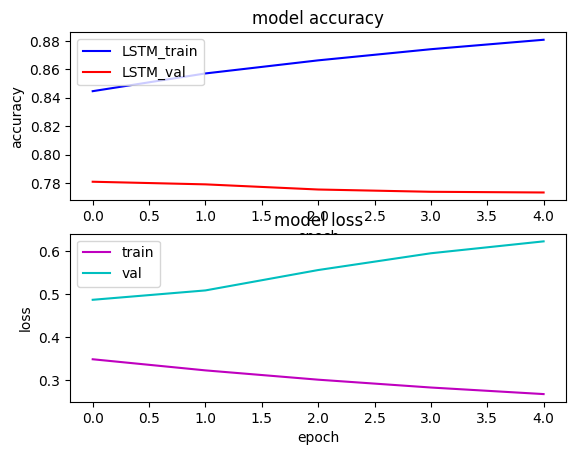

In [106]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
#useful only when more than 1 epoch

In [110]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0
scores = model.predict(x_test, verbose=1, batch_size=10024)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 18s 564ms/step


In [114]:

accuracynlp = accuracy_score(y_test, y_pred_1d)

print(f'Accuracy - nlp: {accuracynlp:.2f}')

print(classification_report(y_test, y_pred_1d))
conf_matrixnlp = confusion_matrix(y_test, y_pred_1d)

Accuracy - nlp: 0.77
              precision    recall  f1-score   support

           0       0.78      0.76      0.77    159911
           1       0.77      0.79      0.78    160089

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



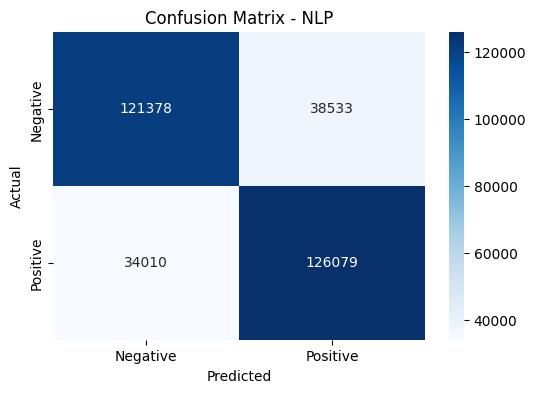

In [115]:

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrixnlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - NLP')
plt.show()

In [116]:
report = classification_report(list(test_data.sentiment), y_pred_1d)
print(report)
accuracy6 = accuracy_score(list(test_data.sentiment), y_pred_1d)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77    159911
           1       0.77      0.79      0.78    160089

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



# 9. COMPARISON

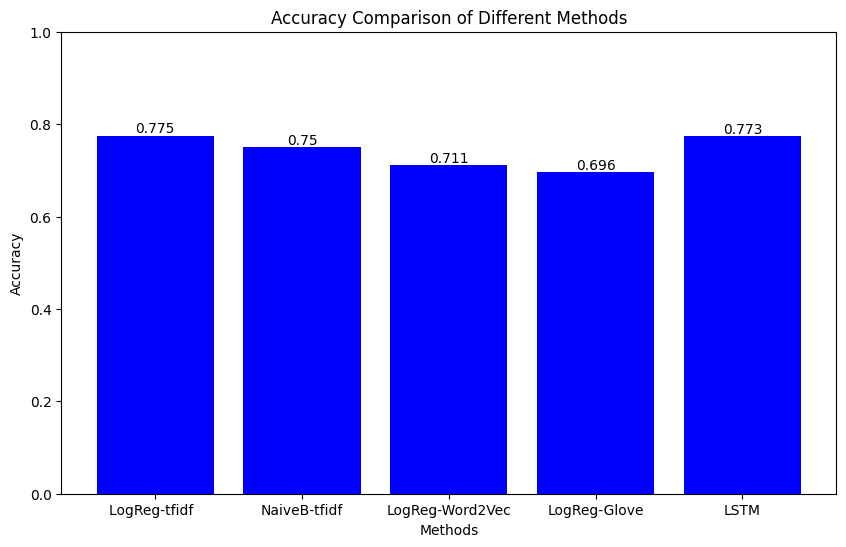

In [119]:
methods = ['LogReg-tfidf  ', 'NaiveB-tfidf', 'LogReg-Word2Vec', 'LogReg-Glove', 'LSTM']



accuracy_values = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy6]


plt.figure(figsize=(10, 6))

plt.bar(methods, accuracy_values, color='blue')
plt.ylim(0, 1) 
plt.title('Accuracy Comparison of Different Methods')

plt.xlabel('Methods')
plt.ylabel('Accuracy')
for i, value in enumerate(accuracy_values):
    plt.text(i, value, round(value,3), ha='center', va='bottom')
plt.show()